# Lightkurve Pipeline
## Import Packages and Define Functions

In [1]:
# import packages needed in this analysis
from lightkurve.correctors import RegressionCorrector, DesignMatrix
import lightkurve as lk  # main package used here
from astropy.timeseries import LombScargle  # the package for periodograms
import astropy.units as u
from astropy.coordinates import Angle
import matplotlib.pyplot as plt  # used for plotting
import matplotlib.ticker as tck
import numpy as np  # used for a few needed methods
from scipy.signal import argrelextrema  # used for searching local minima
from scipy import integrate  # used for calculating the equivalent width
from scipy.signal import find_peaks  # used for searching local maxima
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# this function is designed to search targets from the data set
# with given target WISE ID and returns available sectors of data
def search_target(targetName):
    # subtract the substring with char index
    RA_Hour = target_name[1:3]
    RA_Min = target_name[3:5]
    RA_Sec = target_name[5:10]
    RA_String = RA_Hour+'h'+RA_Min+'m'+RA_Sec+'s'
    # obtain the hour angle with astroPy function Angle()
    RA = str(np.around(Angle(RA_String).degree, 7))

    # similar to the procedures in RA
    DEC_Degree = target_name[10:13]
    DEC_Min = target_name[13:15]
    DEC_Sec = target_name[15:19]
    DEC_String = DEC_Degree+'d'+DEC_Min+'m'+DEC_Sec+'s'
    DEC = np.around(Angle(DEC_String).degree, 7)
    if DEC > 0:
        DEC = '+' + str(DEC)
    else:
        DEC = str(DEC)
    targetString = RA + DEC
    pfs = lk.search_tesscut(targetString)
    return pfs

In [3]:
# this function first zoom into the plot according to the data range in the time interval, then
# draws horizontal lines that represent continuum level and max amplitude on top of the light curve.
def plot_analysis(lightcurve, start=0, end=0, continuum=0, top=0):
    timeseries = lightcurve.time.btjd
    # check whether the given time interval is inside the time series
    if start < np.min(timeseries) or start > np.max(timeseries):
        raise Exception("Time Interval (Starting Date) Out of Bounds!")
    elif end < np.min(timeseries) or end > np.max(timeseries):
        raise Exception("Time Interval (Ending Date) Out of Bounds!")

    # find out the corresponding index of the starting and ending dates
    startIndex = (np.abs(timeseries - start)).argmin()
    endIndex = (np.abs(timeseries - end)).argmin()
    # define the data range given the time interval
    interval = lightcurve[startIndex:endIndex]
    fluxValue = interval.flux.value
    # zoom in
    plt.xlim(start, end)
    plt.ylim(np.min(fluxValue) - 0.005 * np.average(fluxValue),
             np.max(fluxValue) + 0.005 * np.average(fluxValue))

    # draw the accessory lines to label the continuum level and max amplitude change
    if continuum != 0 and top != 0:
        plt.axhline(y=continuum, color='r', linestyle='-',
                    label=f"Continuum Level at {continuum}")
        plt.axhline(y=top, color='r', linestyle='--',
                    label=f"Max Amplitude at {top}")
        plt.legend()
    # if the argument of calling this function is empty
    else:
        pass

In [4]:
# this function is defined to save plots automatically in the folder
# named after the target. The folder itself will then be uploaded to
# the google drive whose link will be updated in the spreadsheet
def save_plot(targetName, fileName):
    path = 'Analyzed Data/' + target_name
    # check whether the directory already exists
    # if yes, then save the plot under that directory
    if os.path.isdir(path):
        plt.savefig(path + '/' + targetName + fileName + '.png')
    # if not, create a directory named after the target
    else:
        os.mkdir(path)
        print(">>>>>>>>>>>> Directory '% s' Created <<<<<<<<<<<<" % targetName)
        plt.savefig(path + '/' + targetName + fileName + '.png')

    print(">>>>>>>>>>>> Figure Saved <<<<<<<<<<<<")

In [5]:
def equivalent_width(frequency, power):
    # generate the 2D local minima matrix
    minima = argrelextrema(power, np.less)[0]
    # the index associated with the highest power
    max_index = np.argmax(power)
    # the frequency with the highest power
    max_frequency = frequency[max_index]
    # the highest power
    max_power = power[max_index]
    start = 0
    end = 0

    if np.argmax(power) == 0:
        # the start index is the max power itself
        start = 0
        # the end index is the next minimum
        end = minima[0]
    else:
        for i in range(len(minima)-1):
            # check whether the current pair of minima are around the peak
            if (frequency[minima[i]] < max_frequency) and (frequency[minima[i+1]] > max_frequency):
                start = minima[i]
                end = minima[i+1]
                # local minima found, break the for loop
                break
            elif i == len(minima)-2:
                start = 0
                end = minima[0]

    if (start == 0) and (end == 0):
        raise Exception("Local Minima Not Found.")
    # calculate the equivalent width by dividing the area with max power
    area = integrate.simps(y=power[start:end], x=frequency[start:end].value)
    width = area / max_power
    return width

In [6]:
# this function returns the width of the largest peak at half power
def half_width(frequency, power):
    # generate the 2D local minima matrix that returns indices of minima
    minima = argrelextrema(power, np.less)[0]
    # the index associated with the highest power
    max_index = np.argmax(power)
    # the frequency with the highest power
    max_frequency = frequency[max_index]
    # the highest power
    max_power = power[max_index]
    start = 0
    end = 0
    width = 0

    # if the periodogram starts from the min frequency, the half width is
    # simply the distance frmo the min frequency to the frequency at half power
    if np.argmax(power) == 0:
        # the start frequency equals the min frequency allowed
        start = 1/13.7
        idx = (np.abs(power[:minima[0]] - max_power/2)).argmin()
        end = frequency[idx].value
        width = end - start
    # if instead there is a single prominent peak, the half width is the distance
    # between the left and the right frequencies at half power
    else:
        for i in range(len(minima)-1):
            # check whether the current pair of minima are around the peak
            if (frequency[minima[i]] < max_frequency) and (frequency[minima[i+1]] > max_frequency):
                left_index = minima[i]
                right_index = minima[i+1]
                # local minima found, break the for loop
                break
            elif i == len(minima)-2:
                left_index = 0
                right_index = minima[0]
        # the start frequency is the left frequency at half max power
        idx_start = (np.abs(power[left_index:max_index] - max_power/2)).argmin()
        start = frequency[idx_start+left_index].value
        # the end frequency is the right frequency at half max power
        idx_end = (np.abs(power[max_index:right_index] - max_power/2)).argmin()
        end = frequency[idx_end+max_index].value
        width = end - start

    return width

In [7]:
# this function takes the frequency and power arrays and returns
# the ratio of max power to the second highest power
def peak_ratio(frequency, power):
    # obtain the local maxima array with scipy package
    peaks, _ = find_peaks(power)
    # generate the peak power array with peak indices
    peak_power = power[peaks]
    # sort the peak power array to find the first and second highest peaks
    peak_sorted = sorted(peak_power)
    first_peak = peak_sorted[-1]
    second_peak = peak_sorted[-2]
    # calculate the ratio
    ratio = first_peak / second_peak
    return ratio

## Searching and downloading
To search for an individual target, use the *search_tesscut* function in the *Lightkurve* package. This function returns lightcurve data from the TESS mission and a *SearchResult* table which contains information about the data products available to download. TESS FFI cutouts are downloaded as *TargetPixelFile* objects. This is done with the argument *cutout_size*, which describes the number of pixels along the side of the cutout, and can be an *int* or a *tuple*.

In [16]:
# the name of the target
target_name = 'J063215.41-681259.2'
# do the search
pfs = search_target(target_name)
pfs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESScut,1426,98.0642083-68.2164444,0.0
1,TESS Sector 02,2018,TESScut,1426,98.0642083-68.2164444,0.0
2,TESS Sector 03,2018,TESScut,1426,98.0642083-68.2164444,0.0
3,TESS Sector 04,2018,TESScut,1426,98.0642083-68.2164444,0.0
4,TESS Sector 05,2018,TESScut,1426,98.0642083-68.2164444,0.0
5,TESS Sector 06,2018,TESScut,1426,98.0642083-68.2164444,0.0
6,TESS Sector 08,2019,TESScut,1426,98.0642083-68.2164444,0.0
7,TESS Sector 09,2019,TESScut,1426,98.0642083-68.2164444,0.0
8,TESS Sector 10,2019,TESScut,1426,98.0642083-68.2164444,0.0


In [34]:
# download the list of pixel files of the chosen sector
chosen_pf = pfs[4]
pf = chosen_pf.download(cutout_size=25)
# interact
pf.interact()

>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


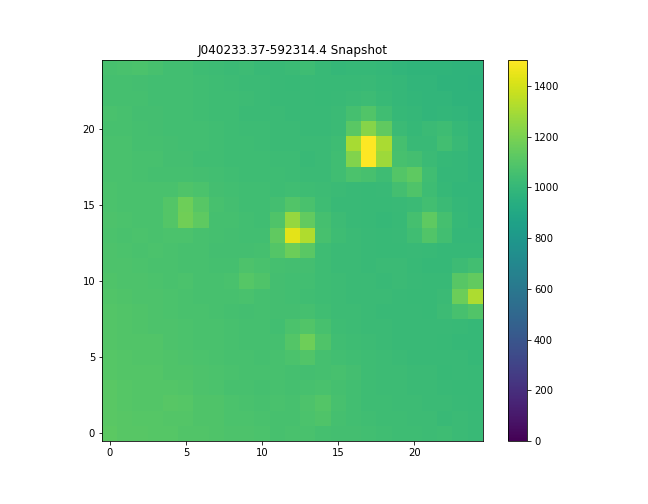

In [82]:
%matplotlib widget

# The following snippet generates an interactive plot that shows
# information of selected pixels in the graph. The max color limit
# can be adjusted to present faint targets and find clean background.
frame_num = 90
snapforEdit = pf.flux[frame_num].value + pf.flux_bkg[frame_num].value
plt.figure(figsize=(9, 7))
plt.imshow(snapforEdit, origin='lower', aspect='equal')
plt.colorbar()
plt.clim(0, 1500)
plt.title(target_name + ' Snapshot')
save_plot(target_name, 'Snapshot')
plt.show()

## Cleaning the raw data
TESS data is influenced by scattered light signals that sometimes are hard to predict. To best check if variability is inherent to an object versus from TESS detected scattered light (or any other signal from TESS systematics), one needs to look at the lightcurve for a **neighboring object**. The 3rd segement of code does just that. (Note: the best neighbors for the "neighbor test" are stars **nearby** and of **comparable brightness**).

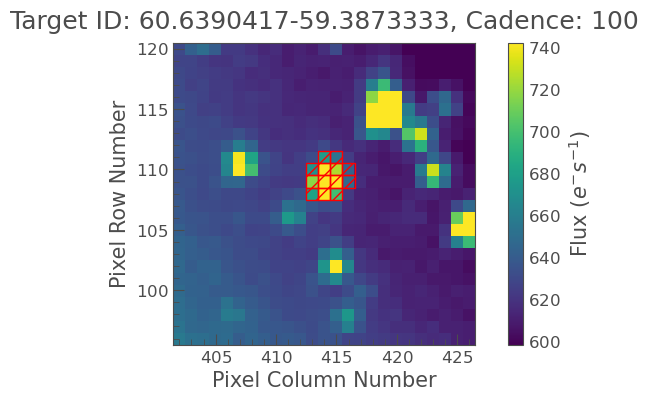

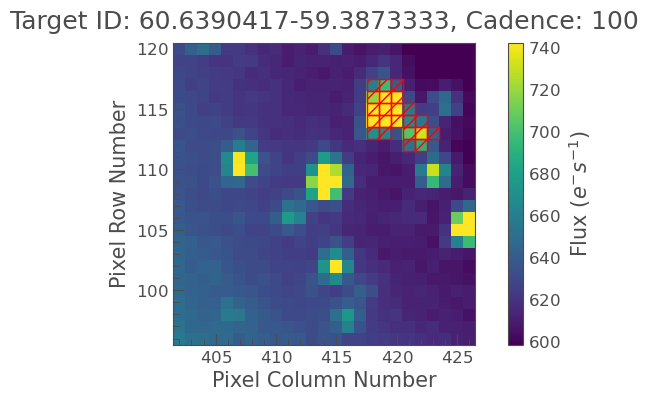

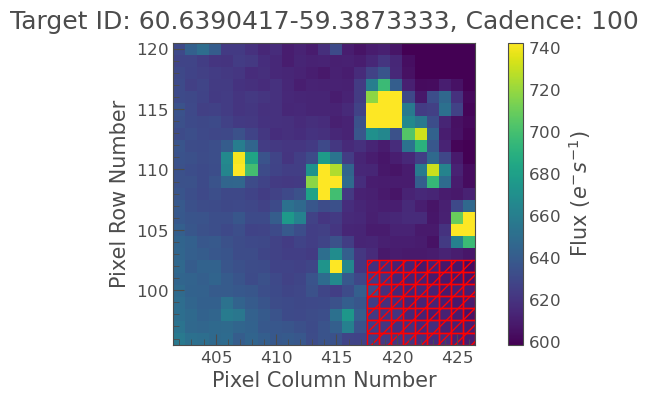

In [83]:
%matplotlib inline

# create a mask using a threshold, changing the threshold lower will
# include more pixels, higher leads to narrower pixel coverage
faint_target = False
if faint_target:
    t_mask = np.zeros((pf.shape[1:]), dtype='bool')
    t_mask[12:14, 12:14] = True
else:
    t_mask = pf.create_threshold_mask(threshold=10)

# show the image for some frame number with the threshold mask
# overlaid to check how good it is
pf.plot(frame=100, aperture_mask=t_mask)

# create custom mask for neighbor (used for scattered light removal ),
# change reference pixel to sample different neighbors
# reference coordinate for neighbor is (x,y)
neighbor_mask = pf.create_threshold_mask(threshold=10, reference_pixel=(17, 19))
pf.plot(frame=100, aperture_mask=neighbor_mask)

# create custom mask method for background (to use for scattered light removal)
# The index ranges give define the pixels used in the y,x direction.
# reference coordinate for background is (y,x)
background_mask = np.zeros((pf.shape[1:]), dtype='bool')
background_mask[0:7, 16:25] = True
pf.plot(frame=100, aperture_mask=background_mask)

plt.show()

>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<
>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


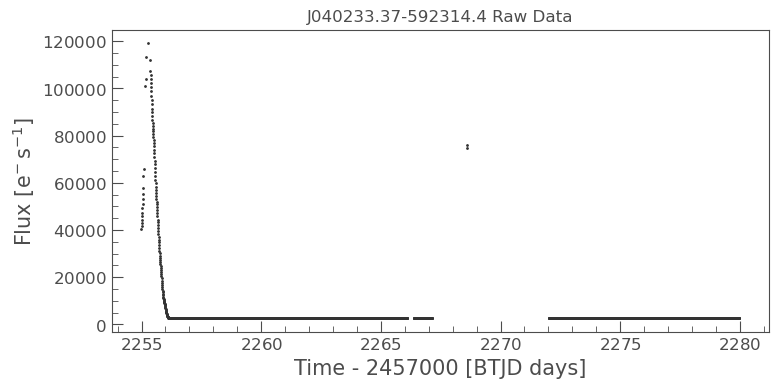

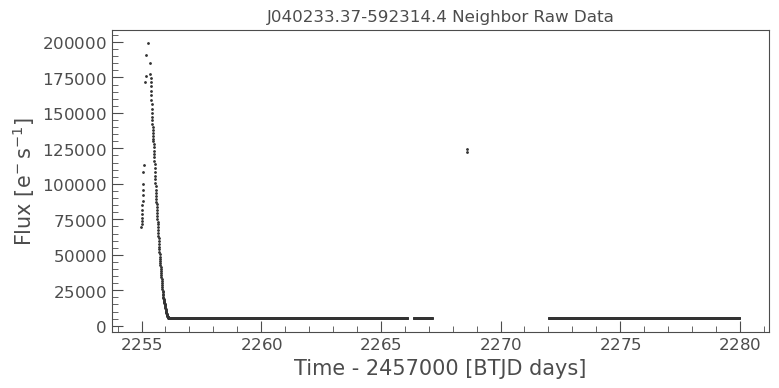

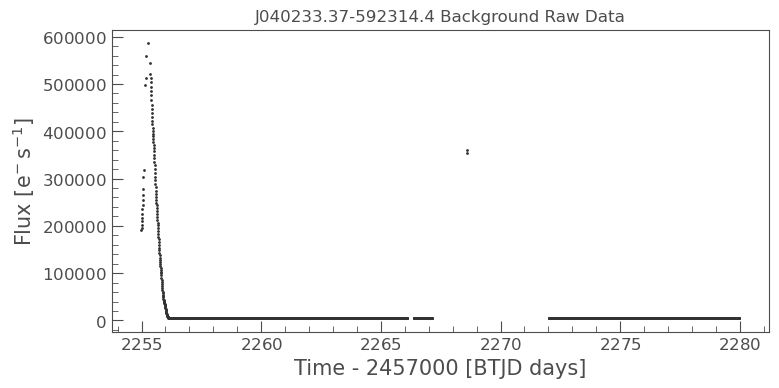

In [84]:
%matplotlib inline

lc_raw = pf.to_lightcurve(aperture_mask=t_mask)
timevalues = lc_raw.time.btjd
lc_raw.scatter()
plt.title(target_name + ' Raw Data')
save_plot(target_name, 'Raw Data')  # save the plot

# show the neighbor's lightcurve as well:
lc_neighb = pf.to_lightcurve(aperture_mask=neighbor_mask)
lc_neighb.scatter()
plt.title(target_name + ' Neighbor Raw Data')

# plot the flux from the mostly empty background aperature
lc_backg = pf.to_lightcurve(aperture_mask=background_mask)
lc_backg.scatter()
plt.title(target_name + ' Background Raw Data')
save_plot(target_name, 'Background Data')  # save the plot
plt.show()

>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


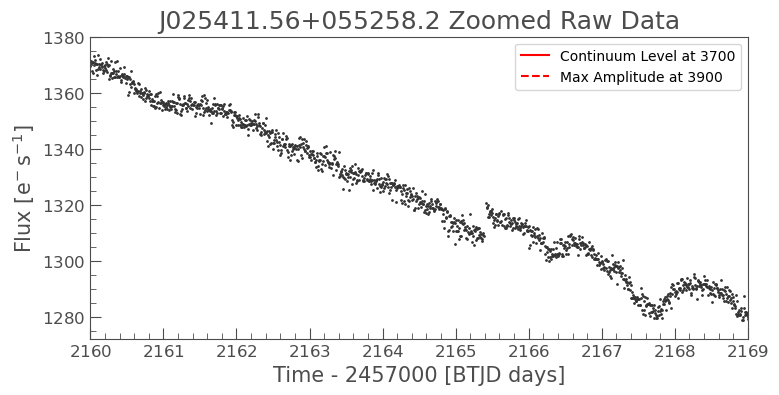

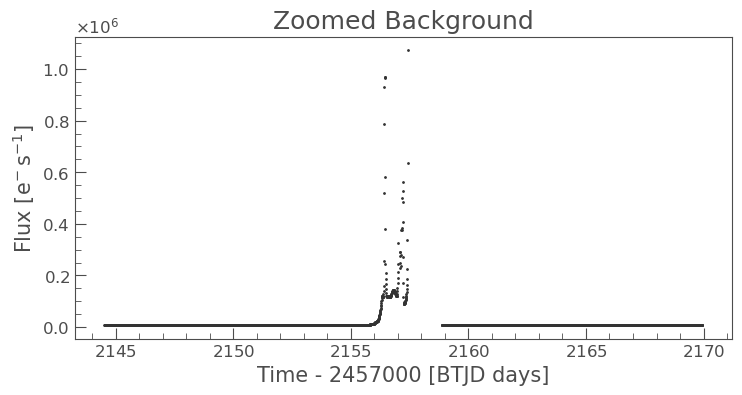

In [41]:
%matplotlib inline

# change x_low, x_up, y_low1, y_up1 etc. (#1 used for target y ranges,
# #2 for neighboor) to zoom into new areas of the lightcurves displayed above
x_low, x_up = 2160, 2169

lc_raw.scatter()
plot_analysis(lc_raw, x_low, x_up, 3700, 3900)
plt.title(target_name + ' Zoomed Raw Data', fontsize=18)
save_plot(target_name, 'Zoomed Raw Data')  # save the plot

# plot neighbor or background zoom as well
# lc_neighb.scatter()
lc_backg.scatter()
# plot_analysis(lc_backg, x_low, x_up)
plt.title('Zoomed Background', fontsize=18)

plt.show()

### Using a "*ReggresionCorrector*"
*Lightkurve* offers the class *RegressionCorrector* which can be used to remove instrument noise and systematics. The only parameter to tweak is the number of components used for the "principal component analysis" that is performed by this class (usually 3 to 5 for this task).

##### IMPORTANT: Only use this if its really necessary, as it could modify things like the shape of RR Lyraes. Typically the following algorithms are not needed for cleaning the data.

>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


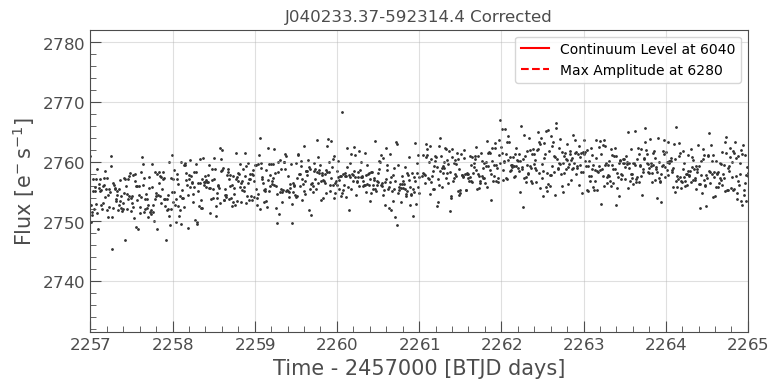

In [86]:
%matplotlib inline

needs_regression_corrector = True
# choose one final number of components
components = 3
# choose one method of light curve correction
bkd_correction = False
invert_correction = True

if needs_regression_corrector:
    clean_bkd = lc_backg

    if bkd_correction:
        # remove nans in the selected background
        clean_bkd = lc_backg.remove_nans().flux
    elif invert_correction:
        # remove nans in the inverted background
        clean_bkd = pf.to_lightcurve(aperture_mask=~t_mask).remove_nans().flux

    clean_raw = lc_raw.remove_nans()  # remove nans in raw data light curve
    dm = DesignMatrix(clean_bkd,
                      name='regressors').pca(components).append_constant()
    rc = RegressionCorrector(clean_raw)
    corrected_lc = rc.correct(dm)

    # Remove the scattered light
    corrected_lc = clean_raw - rc.model_lc + np.percentile(rc.model_lc.flux, 5)
    corrected_lc.scatter()
    plt.title(target_name + " Corrected")
    plot_analysis(corrected_lc, 2257, 2265, 6040, 6280)
    plt.grid(alpha=0.4)
    save_plot(target_name, 'Corrected')  # save the plot

## Adding conditions to the time
Usually, part of the data is really not that good, and thus should be removed before analyzing it. Adding a **time mask** is one way to do so.

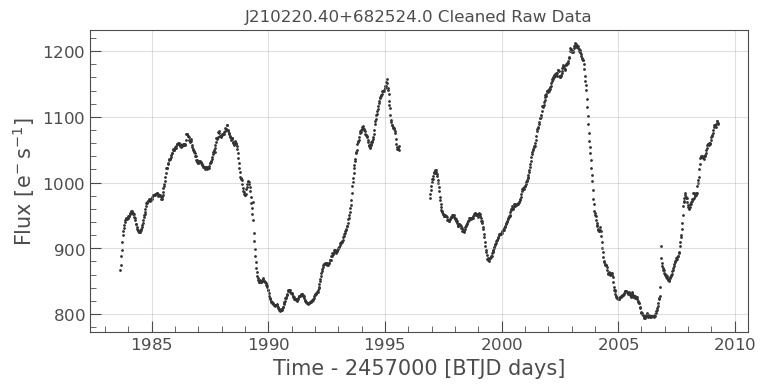

In [28]:
%matplotlib inline

needs_time_conditions = False

start1, end1 = 2474, 2484
start2, end2 = 2487, 2499
indx1 = (np.abs(timevalues - start1)).argmin()
indx2 = (np.abs(timevalues - end1)).argmin()
indx3 = (np.abs(timevalues - start2)).argmin()
indx4 = (np.abs(timevalues - end2)).argmin()

if needs_time_conditions:
    lc_clean = corrected_lc[indx1:indx2]
    lc_clean = lc_clean.append(corrected_lc[indx3:indx4])
else:
    lc_clean = corrected_lc

clean_lc_plot = lc_clean.scatter()
plt.title(target_name + ' Cleaned Raw Data')
plt.grid(alpha=0.4)

### Flattening
In some cases, there are some long-term trends that we are not intrested in. To eliminate them, we can use the *flatten* method.

>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


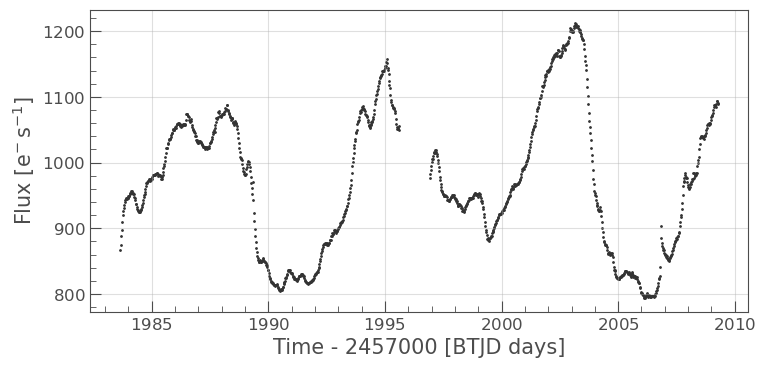

In [29]:
%matplotlib inline

needs_flatten = False

if needs_flatten:
    # flatten the clean lc
    # lc_no_trends = corrected_lc.flatten()
    lc_no_trends = lc_clean.flatten(polyorder=1)
else:
    lc_no_trends = lc_clean

# plot the result
lc_no_trends.scatter()
plt.grid(alpha=0.4)
# plt.xlim(1480, 1489)
# plt.ylim(28300, 28600)
save_plot(target_name, 'Flattened')  # save the plot
plt.show()

### Extra conditions
Sometimes add some extra conditions need to be applied, and that is what this cell is for.

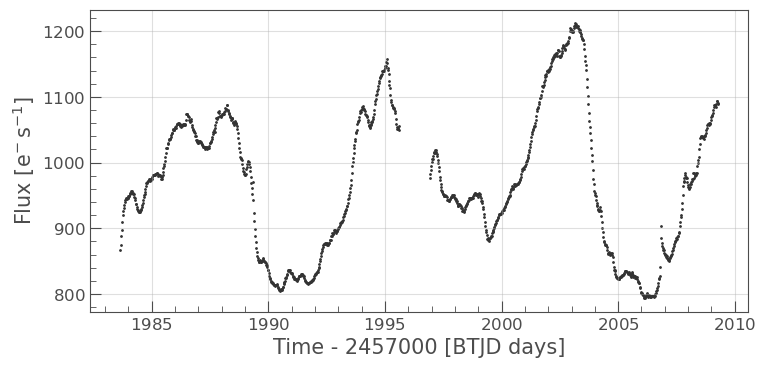

In [30]:
%matplotlib inline

needs_extra_conditions = False

if needs_extra_conditions:
    # Here write all the extra conditions needed
    # extra_conditions = (lc_no_trends.time < 1825) | (lc_no_trends.time > 1830)
    # lc_final = lc_no_trends[extra_conditions]
    lc_final = lc_no_trends

else:
    lc_final = lc_no_trends

# plot the final lc
lc_final.scatter()
plt.grid(alpha=0.4)
# plot_analysis(1507, 1355, 1365)

## Analyzing the data
The main idea of this final section is to find any short term periodicity that the target may present.

### Creating a periodogram

The estimated period is 7.60 days.
The false alarm probability is 0.0000000000 %.
The equivalent width is 0.03526.
The width at half peak width is 0.03434.
The ratio of first peak to second peak is 6.33.
>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


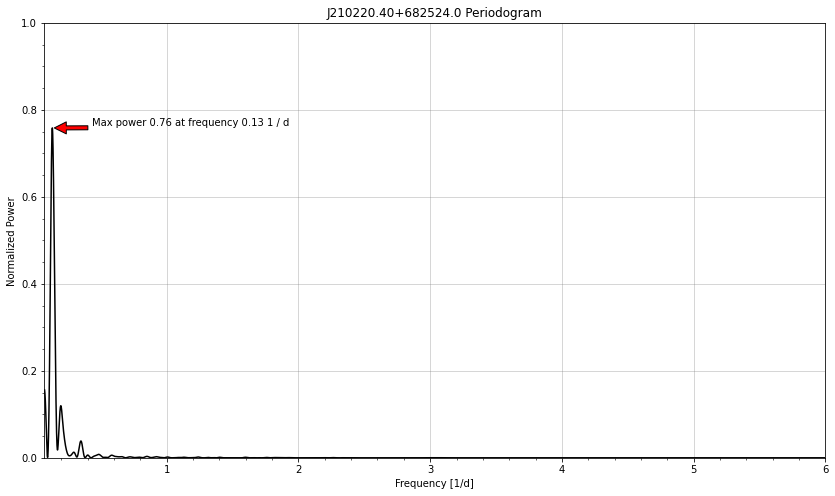

In [31]:
%matplotlib inline

# subtract necessary information from the lightcurve object
time = lc_final.time.btjd * u.day
flux = lc_final.flux
error = lc_final.flux_err
# create normalized Lomb Scargle Periodogram
ls = LombScargle(time, flux, error, normalization='standard')
# the min is set as '1/13.7' so that at least one period can be observed, the max is
# set as '6' since at least eight observations are needed to validate the variability
frequency, power = ls.autopower(minimum_frequency=1/(13.7*u.day),
                                maximum_frequency=6/(1*u.day),
                                samples_per_peak=200)
# the frequency with the highest power
max_frequency = frequency[np.argmax(power)]
# the highest power
max_power = power.max()

period_found = 1 / max_frequency
print(f"The estimated period is {period_found.value:.2f} days.")
false_prob = ls.false_alarm_probability(max_power)
print(f"The false alarm probability is {false_prob * 100:.10f} %.")
equiv_width = equivalent_width(frequency, power)
print(f"The equivalent width is {equiv_width:.5f}.")
half_peak_width = half_width(frequency, power)
print(f"The width at half peak width is {half_peak_width:.5f}.")
power_ratio = peak_ratio(frequency, power)
print(f"The ratio of first peak to second peak is {power_ratio:.2f}.")

# visualize the normalized periodogram
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)
ax.plot(frequency, power, color='black')
ax.set(xlabel='Frequency [1/d]', xlim=[0.07, 6],
       ylabel='Normalized Power', ylim=[0, 1],
       title=target_name+' Periodogram')
ax.annotate(f"Max power {max_power:.2f} at frequency {max_frequency:.2f}",
            xy=(max_frequency.value, max_power),
            xytext=(max_frequency.value+0.3, max_power+0.005),
            arrowprops=dict(facecolor='red',
                            shrink=0.05))
ax.grid(color='gray', alpha=0.4)
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
save_plot(target_name, 'Periodgram')  # save the plot
plt.show()

### Folding the lightcurve
To fold the data using an integer multiple of the period, just change the integer multiplying the *period_found* that is a parameter of the *fold* method. In adition, the binsize could be changed to a different number to reduce the noise in the result. 

>>>>>>>>>>>> Figure Saved <<<<<<<<<<<<


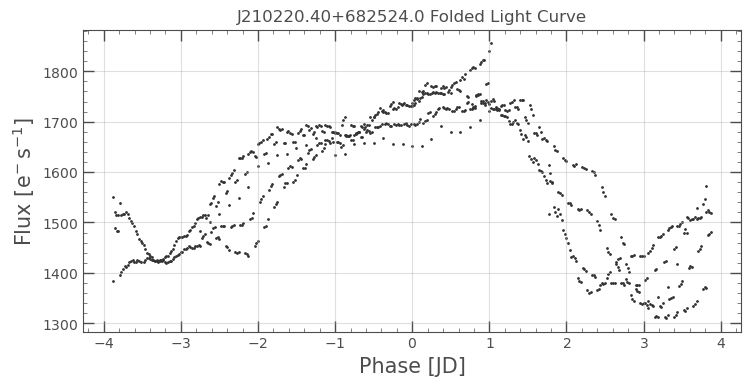

In [119]:
%matplotlib inline

# fold using an integer multiple of the period found from the periodogram
folded_lc_plot = lc_final.fold(period_found).bin(time_bin_size=0.001).scatter()
# add more feautures to the plot
plt.title(target_name + ' Folded Light Curve')

plt.minorticks_on()

plt.tick_params(direction='in', length=8, width=1,
                labelsize=10, right=True, top=True)
plt.tick_params(direction='in', length=3, width=0.5,
                which='minor', right=True, top=True)

plt.grid(alpha=0.4)
save_plot(target_name, 'Folded Light Curve')  # save the plot
plt.show()